In [80]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer, load_wine
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import precision_score, recall_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification


In [81]:
def create_H(X, y, num_hypotheses=200, noise_scale=0.2, n_init=10):
    """
    Génère H en utilisant une stratégie 'Warm Start'.
    
    Arguments:
    - n_init : Nombre de labels 'achetés' au début pour orienter la recherche.
               C'est ce qui rend l'approche légitime (on paie pour l'info).
    """
    N, d = X.shape
    H = []
    S_init = [] # Pour stocker les points dont on a utilisé les labels
    
    w_base, b_base = None, None
    attempts = 0

    # 1. Essayer de trouver une direction avec un petit budget de labels
    while attempts < 20:
        # On tire n_init points au hasard
        idx = np.random.choice(N, size=n_init, replace=False)
        X_init, y_init = X[idx], y[idx]
        
        # Vérification : A-t-on les deux classes ?
        if len(np.unique(y_init)) > 1:
            # Si oui, on entraîne une régression logistique RAPIDE et GROSSIÈRE
            clf = LogisticRegression(solver='liblinear', C=1.0)
            clf.fit(X_init, y_init)
            
            w_base = clf.coef_[0]
            b_base = clf.intercept_[0]
            
            # Normalisation (important pour que le bruit soit cohérent)
            norm = np.linalg.norm(w_base) + 1e-9
            w_base /= norm
            b_base /= norm
            
            # On enregistre ces points comme "déjà vus"
            for x_val, y_val in zip(X_init, y_init):
                S_init.append((x_val, y_val))
            
            break
        attempts += 1
    
    # 2. Fallback : Si on n'a pas réussi (ex: que des 0 dans les 10 points), on utilise la PCA
    # La PCA est "Agnostique" (approche 2) car elle n'utilise PAS les labels.
    if w_base is None:
        print("Warm start échoué (classes déséquilibrées), fallback sur PCA (Non-supervisé)")
        pca = PCA(n_components=1).fit(X)
        w_base = pca.components_[0]
        b_base = 0.0 # On coupe au milieu par défaut
        # S_init reste vide ou on peut décider d'ajouter les points quand même

    # 3. Génération de H par perturbation autour de w_base
    for _ in range(num_hypotheses):
        # On ajoute du bruit directionnel
        w = w_base + (np.random.randn(d) * noise_scale)
        w = w / np.linalg.norm(w)
        
        # On ajoute du bruit sur le biais
        b = b_base + (np.random.randn() * noise_scale)
        
        # Optionnel : Recentrage Data-Dependent (Approche 2 améliorée)
        # b = -np.dot(w, X[np.random.randint(N)]) 
        
        H.append(lambda x, w=w, b=b: 1 if np.dot(w, x) + b >= 0 else 0)

    return H, S_init

In [82]:
def oracle_factory(X_pool, Y_pool):
    """
    Renvoie une fonction oracle qui retourne le vrai label du point x.
    On suppose que x appartient au pool exact.
    """
    def oracle(x):
        # Cherche l'indice exact dans le pool
        idx = np.where(np.all(X_pool == x, axis=1))[0]
        if len(idx) == 0:
            raise ValueError("x n'est pas dans le pool")
        return Y_pool[idx[0]]
    return oracle

In [83]:
def DisagreeD(Hi, Di, threshold):
    """
    Fraction de points dans Di où il existe un désaccord
    entre les hypothèses Hi.
    """
    if len(Hi) <= 1 or len(Di) == 0:
        return 0.0

    disagree_count = 0
    for x in Di:
        # Convertir chaque prédiction en tuple pour que set() fonctionne
        predictions = [tuple(np.atleast_1d(h(x))) for h in Hi]
        if len(set(predictions)) > 1:
            disagree_count += 1

    return disagree_count / len(Di)


In [84]:
def UB(S_i, H_i, delta_k, scale): # <--- Ajoutez scale=0.1 (très agressif)
    n = len(S_i)
    if n == 0:
        return np.ones(len(H_i))
    
    # On multiplie la borne par 'scale'. 
    # Plus scale est petit, plus l'intervalle est serré, plus on élimine vite.
    bound = scale * np.sqrt(np.log(2/ delta_k) / (2 * n)) 
    
    UBs = []
    for h in H_i:
        X_s, y_s = zip(*S_i)
        X_s = np.array(X_s)
        y_s = np.array(y_s)
        y_pred = np.array([h(x) for x in X_s])
        err_hat = np.mean(y_pred != y_s)
        UBs.append(min(1.0, err_hat + bound))
    return np.array(UBs)

def LB(S_i, H_i, delta_k, scale): # <--- Ajoutez scale=0.1 ici aussi
    n = len(S_i)
    if n == 0:
        return np.zeros(len(H_i))
    
    bound = scale * np.sqrt(np.log(2/ delta_k) / (2 * n))
    
    LBs = []
    for h in H_i:
        X_s, y_s = zip(*S_i)
        X_s = np.array(X_s)
        y_s = np.array(y_s)
        y_pred = np.array([h(x) for x in X_s])
        err_hat = np.mean(y_pred != y_s)
        LBs.append(max(0.0, err_hat - bound))
    return np.array(LBs)

In [85]:
def sample_uncertain_points(D_i, H_i, S_i):
    """
    Rejection sampling: échantillonne des points incertains.
    
    Paramètres:
        D_i : liste des points du dataset restant
        H_i : liste des hypothèses
        S_i : liste des points déjà étiquetés
    Retour:
        uncertain_points : liste de points x ∈ D_i où ∃ h1,h2 ∈ H_i: h1(x) ≠ h2(x)
    """
    n_samples = 2*len(S_i) + 1
    uncertain_points = []

    # Construire l'ensemble des points déjà étiquetés
    labeled_set = {tuple(x[0]) for x in S_i}

    # Mélanger D_i pour l'échantillonnage aléatoire
    D_i_shuffled = D_i.copy()
    random.shuffle(D_i_shuffled)

    for x in D_i_shuffled:
        if tuple(x) in labeled_set:
            continue  # ne pas réutiliser un point déjà étiqueté

        # Vérifier si x est incertain
        predictions = [h(x) for h in H_i]
        if len(set(predictions)) > 1:  # au moins deux hypothèses différentes
            uncertain_points.append(x)
            if len(uncertain_points) >= n_samples:
                break

    return uncertain_points


In [86]:
def A2(H, D, oracle, epsilon, delta, max_iter, threshold, scale, initial_S=None):
    i = 1
    D_i = [tuple(x) for x in D]  # convertit chaque array en tuple hashable
    H_i = list(H)
    if initial_S is None:
        S_i = []
    else:
        S_i = list(initial_S)
    k = 1
    history = {"iters": []}
    
    DIS = DisagreeD(H_i, D_i, threshold)
    UB_vals = UB(S_i, H_i, delta/(k*(k+1)),scale)
    LB_vals = LB(S_i, H_i, delta/(k*(k+1)),scale)
    metric = DIS * (min(UB_vals) - min(LB_vals))

    history["iters"].append({
        "step": 0,
        "n_labels": len(S_i),
        "H_snapshot": H_i.copy(),
        "DIS": DIS,
        "UB": UB_vals,
        "LB": LB_vals,
        "metric": metric
    })
    prev_metric = metric

    while metric > epsilon:
        if i*k>max_iter:
            print(f"Limite max_iter atteinte à l'itération {i}, k={k}")
            break
        #1
        S_i_prim = []
        H_i_prim = H_i  # on évite .copy() coûteux
        k = k + 1
        #2
        while DisagreeD(H_i_prim, D_i, threshold) >= 0.5 * DisagreeD(H_i, D_i, threshold):
            if i*k >= max_iter:
                print(f"Limite max_iter atteinte à l'itération {i}, k={k}")
                break
            delta_k = delta / (k*(k+1))

            # Calculer métriques
            LB_vals = LB(S_i, H_i_prim, delta_k, scale)
            UB_vals = UB(S_i, H_i_prim, delta_k,scale)
            DIS = DisagreeD(H_i_prim, D_i, threshold)
            metric = DIS * (min(UB_vals) - min(LB_vals))

            # --- Sauvegarde à CHAQUE étape ---
            history["iters"].append({
                "step": i*k,
                "n_labels": len(S_i),
                "H_snapshot": H_i_prim.copy(),
                "DIS": DIS,
                "UB": UB_vals,
                "LB": LB_vals,
                "metric": metric
            })
            print(f"Iteration {i}, k={k}, #labels={len(S_i)}, #hypotheses={len(H_i_prim)}, DIS={DIS}, metric={metric:.4f}")

            '''
            if metric > prev_metric + 1e-6:
                print(f"Metric a augmenté à l'étape {i*k} ({prev_metric:.4f} → {metric:.4f}), arrêt de l'exécution")
                h_star = H_i_prim[np.argmin(UB_vals)]
                return h_star, S_i, history
            prev_metric = metric
            '''
            #(a) condition d'arrêt interne
            if metric <= epsilon:
                #(b)
                print(f"Condition d'arrêt interne atteinte à l'itération {i}, k={k}")
                h = H_i_prim[np.argmin(UB_vals)]
                return h, S_i, history

            #(c) sinon
            else:
                # i. Rejection sampling limité
                S_i_prim = sample_uncertain_points(D_i, H_i_prim, S_i)
                if len(S_i_prim) == 0:
                    print("Plus de points incertains à échantillonner, arrêt.")
                    h_star = H_i_prim[np.argmin(UB_vals)]
                    return h_star, S_i, history


                # ii. Ajouter les points étiquetés
                S_i.extend([(x, oracle(np.array(x))) for x in S_i_prim if tuple(x) not in {tuple(y[0]) for y in S_i}])

                # iii. Mettre à jour H_i_prim
                #min_UB = np.min(UB_vals)
                #H_i_prim = [h for h, lb in zip(H_i_prim, LB_vals) if lb <= min_UB]

                UB_vals_prim = UB(S_i, H_i_prim, delta_k, scale)
                LB_vals_prim = LB(S_i, H_i_prim, delta_k,scale)
                min_UB_prim = np.min(UB_vals_prim)
                H_i_prim = [h for h, lb in zip(H_i_prim, LB_vals_prim) if lb <= min_UB_prim]

                k = k + 1

        #3. Mise à jour H_i et D_i
        H_i = H_i_prim
        D_i = [x for x in D_i if len(set(h(x) for h in H_i_prim)) > 1]
        i = i + 1

        # Sauvegarde à la fin de l'itération principale
        DIS = DisagreeD(H_i, D_i, threshold)
        UB_vals = UB(S_i, H_i, delta/(k*(k+1)),scale)
        LB_vals = LB(S_i, H_i, delta/(k*(k+1)),scale)
        metric = DIS * (min(UB_vals) - min(LB_vals))
    print("Condition d'arrêt atteinte.")
    delta_k = delta / (k*(k+1))
    UB_vals = UB(S_i, H_i, delta_k, scale)
    h_star = H_i[np.argmin(UB_vals)]
    return h_star, S_i, history


In [87]:
class FunctionClassifier:
    def __init__(self, h):
        self.h = h
    def predict(self, X):
        return np.array([self.h(x) for x in X])


In [88]:
def plot_dataset_visualizations_avg(
        X, y, 
        all_results,
        X_test=None, y_test=None,
        X_train=None, y_train=None,
        title="Visualisation A² Moyenne"
    ):
    """
    Visualisation complète pour un dataset avec résultats moyens sur plusieurs runs.
    Affiche 10 sous-graphes :
    1) Points colorés selon labels
    2) Matrice de confusion A²
    3) Test Accuracy moyenne
    4) Nombre d'échantillons labellisés / train
    5) Points labellisés par A²
    6) Heatmap + Outliers + A² queries
    7) Precision / Recall moyenne sur Test
    8) Convergence A² (moyenne)
    9) Comparaison erreurs A² vs passifs
    10) Temps d'exécution moyen
    """

    # --- Récupération du dernier résultat (moyennes déjà calculées) ---
    r = all_results[-1]
    dataset_name = r["dataset"]
    A2_res = r["A2"]
    passive_results = r["passive"]

    # PCA pour visualisation si plus de 2 features
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
        X_test_vis = pca.transform(X_test) if X_test is not None else None
    else:
        X_vis = X.copy()
        X_test_vis = X_test.copy() if X_test is not None else None

    fig, axes = plt.subplots(6, 2, figsize=(18, 25))  
    ax = axes.ravel()

    # ===================================================
    # 1) Points colorés selon label
    # ===================================================
    ax[0].scatter(X_vis[:,0], X_vis[:,1], c=['red' if lab==0 else 'blue' for lab in y], s=20)
    ax[0].set_title("1) Points colorés selon labels")
    ax[0].grid(True)

    # ===================================================
    # 2) Matrice de confusion A²
    # ===================================================
    if X_test is not None:
        y_pred_test = r["A2"].get("model_pred_test", np.zeros_like(y_test))
        cm = confusion_matrix(y_test, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
        disp.plot(ax=ax[1], cmap='Blues', colorbar=True)
        ax[1].set_title("2) Matrice de confusion du learner")
    else:
        ax[1].text(0.5,0.5,"Pas de learner fourni", ha='center')

    # ===================================================
    # 3) Test Accuracy moyenne
    # ===================================================
    labels = ["A² Active"] + list(passive_results.keys())
    accs = [A2_res["test"]["accuracy"]] + [v["test_metrics"]["accuracy"] for v in passive_results.values()]
    ax[2].bar(labels, accs, color=['green'] + ['blue']*len(passive_results))
    ax[2].set_ylim(0,1)
    ax[2].set_ylabel("Test Accuracy")
    ax[2].set_title("3) Test Accuracy Moyenne")
    ax[2].tick_params(axis='x', rotation=30)
    ax[2].grid(axis='y', linestyle='--', alpha=0.7)

    # ===================================================
    # 4) Nombre d'échantillons labellisés / train
    # ===================================================
    n_labels = A2_res.get("n_labeled", 0)
    counts = [n_labels] + [len(X_train)] * len(passive_results)
    ax[3].bar(labels, counts, color=['green'] + ['blue']*len(passive_results))
    ax[3].set_ylabel("Nombre d'échantillons")
    ax[3].set_title("4) Nombre d'échantillons pour actif et passifs")
    ax[3].tick_params(axis='x', rotation=30)
    ax[3].grid(axis='y', linestyle='--', alpha=0.7)

    # ===================================================
    # 5) Points labellisés par A²
    # ===================================================
    ax[4].scatter(X_vis[:,0], X_vis[:,1], c='lightgray', s=20)
    if "S_labeled" in A2_res and len(A2_res["S_labeled"])>0:
        X_labeled_vis = np.array([pca.transform(np.array(x[0]).reshape(1,-1))[0] if X.shape[1]>2 else x[0] 
                                  for x in A2_res["S_labeled"]])
        ax[4].scatter(X_labeled_vis[:,0], X_labeled_vis[:,1], c='green', s=50,
                      label=f"A² Labeled ({len(X_labeled_vis)} points)")
    ax[4].set_title("5) Points labellisés par A²")
    ax[4].grid(True)
    ax[4].legend()

    # ===================================================
    # 6) Heatmap + Outliers + A² queries
    # ===================================================
    ax[5].set_title("6) Heatmap + Outliers + A² Queries")
    ax[5].grid(True)
    colors_map = ['Reds','Blues']
    class_colors = ['red','blue']
    heatmaps, points, outlier_handles = [], [], []

    for label in np.unique(y):
        X_class = X_vis[y==label]
        kde = gaussian_kde(X_class.T)
        x_min, x_max = X_class[:,0].min()-1, X_class[:,0].max()+1
        y_min, y_max = X_class[:,1].min()-1, X_class[:,1].max()+1
        xx, yy = np.meshgrid(np.linspace(x_min,x_max,100), np.linspace(y_min,y_max,100))
        density = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax[5].contourf(xx, yy, density, levels=20, alpha=0.3, cmap=colors_map[label])
        heatmaps.append(Patch(color=plt.colormaps[colors_map[label]](0.6), label=f"Heatmap classe {label}"))
        ax[5].scatter(X_class[:,0], X_class[:,1], c=class_colors[label], s=20)
        points.append(Line2D([0],[0], marker='o', color='w', label=f"Points classe {label}",
                             markerfacecolor=class_colors[label], markersize=7))
        # Outliers
        centroid = X_class.mean(axis=0)
        distances = np.linalg.norm(X_class - centroid, axis=1)
        out_idx = np.argsort(distances)[-5:]
        ax[5].scatter(X_class[out_idx,0], X_class[out_idx,1], facecolors='none', edgecolors='black', s=100)
        outlier_handles.append(Line2D([0],[0], marker='o', color='w', label=f"Outliers classe {label}",
                                      markerfacecolor='none', markeredgecolor='black', markersize=10))

    # A² queries (SVM margin)
    svm = SVC(kernel='linear').fit(X_vis, y)
    distances = svm.decision_function(X_vis)
    n_queries = min(30, len(X_vis))
    interesting_indices = np.argsort(np.abs(distances))[:n_queries]
    ax[5].scatter(X_vis[interesting_indices,0], X_vis[interesting_indices,1], facecolors='none', edgecolors='green', s=100)
    a2_legend = [Line2D([0],[0], marker='o', color='w', label='A² query',
                         markerfacecolor='none', markeredgecolor='green', markersize=10)]
    ax[5].legend(handles=heatmaps + points + outlier_handles + a2_legend, bbox_to_anchor=(1.05,1), loc='upper left')

    # ===================================================
    # 7) Precision / Recall bar plot moyenne
    # ===================================================
    metrics = ["Precision","Recall"]
    x = np.arange(len(metrics))
    width = 0.15
    offset = 0

    # A²
    ax[6].bar(x+offset, [A2_res["test"]["precision"], A2_res["test"]["recall"]],
              width=width, color='green', alpha=0.6, label="A² Active")
    offset += width

    # Passifs
    passive_colors = ['blue','orange','purple','brown','cyan']
    for i,(name,v) in enumerate(passive_results.items()):
        ax[6].bar(x+offset, [v["test_metrics"]["precision"], v["test_metrics"]["recall"]],
                  width=width, color=passive_colors[i%len(passive_colors)], alpha=0.7, label=name)
        offset += width
    ax[6].set_xticks(x + width*(len(passive_results)+1)/2)
    ax[6].set_xticklabels(metrics)
    ax[6].set_title("7) Precision / Recall Moyenne")
    ax[6].legend()

    # ===================================================
    # 8) Convergence d'A²
    # ===================================================
    ax[7].set_title("8) Convergence d'A²")
    history = A2_res.get("history", None)
    if history is not None and "iters" in history and len(history["iters"])>0:
        metrics_hist = [h["metric"] for h in history["iters"]]
        ax[7].plot(metrics_hist, marker='o')
        ax[7].set_xlabel("Step")
        ax[7].set_ylabel("DISAG*(UB-LB)")
    else:
        ax[7].text(0.5,0.5,"Pas d'historique ou métriques vides", ha='center')
    ax[7].grid(True)

    # ===================================================
    # 9) Comparaison erreurs A² vs passifs
    # ===================================================
    ax[8].set_title("9) Comparaison erreurs")
    if X_test is not None:
        y_pred_test = np.where(r["A2"].get("model_pred_test", None) is None, np.zeros_like(y_test),
                               r["A2"].get("model_pred_test"))
        correct_idx = y_pred_test==y_test
        incorrect_idx = y_pred_test!=y_test
        ax[8].scatter(X_test_vis[correct_idx,0], X_test_vis[correct_idx,1], color='green', s=40)
        ax[8].scatter(X_test_vis[incorrect_idx,0], X_test_vis[incorrect_idx,1], color='red', s=40)
        handles = [Line2D([0],[0], marker='o', color='w', markerfacecolor='green', markersize=7, label='A² Correct'),
                   Line2D([0],[0], marker='o', color='w', markerfacecolor='red', markersize=7, label='A² Incorrect')]

        for i,(name,v) in enumerate(passive_results.items()):
            y_pred = v.get("preds", y_pred_test)
            incorrect_passive = y_pred != y_test
            ax[8].scatter(X_test_vis[incorrect_passive,0], X_test_vis[incorrect_passive,1],
                          facecolors='none', edgecolors=passive_colors[i%len(passive_colors)], s=50)
            handles.append(Line2D([0],[0], marker='o', color='w', markerfacecolor='none',
                                  markeredgecolor=passive_colors[i%len(passive_colors)], markersize=7,
                                  label=f'{name} Incorrect'))
        ax[8].legend(handles=handles, loc='upper right')
    ax[8].grid(True)

    # ===================================================
    # 10) Temps d'exécution moyen
    # ===================================================
    ax[9].set_title("10) Temps d'exécution moyen (s)")
    times = [A2_res.get("time",0)] + [v.get("time",0) for v in passive_results.values()]
    ax[9].bar(labels, times)
    ax[9].set_ylabel("Temps (s)")
    ax[9].tick_params(axis='x', rotation=45)
    ax[9].grid(axis='y', linestyle='--', alpha=0.7)


    # ===================================================
    # 11) Contraction de la région de désaccord
    # ===================================================
    ax[10].set_title("11) Réduction de la région de désaccord (DisagreeD(H_i))")

    history = A2_res.get("history", None)

    if history and "iters" in history and len(history["iters"]) > 0:
        # Extraire les valeurs de DisagreeD à chaque étape
        DIS_hist = [step["DIS"] for step in history["iters"]]
        steps = [step["step"] for step in history["iters"]]

        # Tracer la courbe
        ax[10].plot(steps, DIS_hist, marker='o', linestyle='-', color='purple', label='DisagreeD(H_i)')
        ax[10].set_xlabel("Étape")
        ax[10].set_ylabel("DisagreeD(H_i)")
        ax[10].legend()
        ax[10].grid(True)
    else:
        ax[10].text(0.5, 0.5, "Pas d'historique", ha='center', va='center')
        ax[10].set_xlabel("")
        ax[10].set_ylabel("")
        ax[10].grid(False)


    # ===================================================
    # 12) Garantie de convergence : UB vs erreur réelle
    # ===================================================
    ax[11].set_title("12) Garantie de convergence d'A² (UB vs Test Error)")

    history = A2_res.get("history", None)
    if history and "iters" in history and len(history["iters"]) > 0:
        UB_hist = []
        test_err_hist = []
        for step in history["iters"]:
            UB_snap = step.get("UB", None)
            H_snap = step.get("H_snapshot", None)
            if UB_snap is not None and H_snap is not None and X_test is not None:
                # On prend l'indice de l'hypothèse minimale UB
                best_h_idx = np.argmin(UB_snap)
                UB_hist.append(UB_snap[best_h_idx])
                # Calcul de l'erreur réelle de cette hypothèse sur le test set
                best_h = H_snap[best_h_idx]
                y_pred = np.array([best_h(x) for x in X_test])
                err = 1.0 - accuracy_score(y_test, y_pred)
                test_err_hist.append(err)

        # Tracer UB et erreur réelle
        ax[11].plot(UB_hist, marker='o', linestyle='-', color='purple', label='UB minimale')
        ax[11].plot(test_err_hist, marker='x', linestyle='--', color='green', label='Erreur réelle Test')
        ax[11].set_xlabel("Étape")
        ax[11].set_ylabel("Erreur / UB")
        ax[11].legend()
        ax[11].grid(True)
    else:
        ax[11].text(0.5, 0.5, "Pas d'historique disponible", ha='center', va='center')
        ax[11].set_xlabel("")
        ax[11].set_ylabel("")
        ax[11].grid(False)

    


    plt.suptitle(f"{title} – {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()



In [89]:
def evaluate_classifiers_multiple_runs(
        datasets, epsilon, delta, max_iter,
        num_hypotheses, test_size, num_runs, weight_scale,
        threshold, scale, random_state=42):
    """
    Compare A² à plusieurs classifieurs passifs sur les mêmes données, répété num_runs fois.
    Stocke la moyenne et l'écart-type des métriques train/test pour A² et passifs.
    """
    passive_classifiers = {
        "Naive Bayes": GaussianNB,
        "kNN": lambda: KNeighborsClassifier(n_neighbors=5),
        "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=0),
        "SVM": lambda: SVC(kernel='linear', C=1.0),
        "Logistic Regression": lambda: LogisticRegression(max_iter=200, solver='liblinear')
    }
    
    all_results = []

    for ds in datasets:
        X, y = ds["X"], ds["y"]
        dataset_name = ds["name"]

        # Stocker tous les résultats par run
        run_results_a2 = []
        run_results_passive = {name: [] for name in passive_classifiers}

        for run in range(num_runs):
            # Split différent pour chaque run
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state+run, stratify=y
            )
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # --- A² ---
            X_pool, Y_pool = X_train_scaled.copy(), y_train.copy()
            H, S_init_labels = create_H(X_pool,Y_pool, num_hypotheses, weight_scale)
            oracle = oracle_factory(X_pool, Y_pool)

            start_a2 = time.time()
            print(f"Run {run+1}/{num_runs} on dataset {dataset_name} with A²")
            h_star_func, S_final, history = A2(H, X_pool, oracle, epsilon=epsilon, delta=delta, max_iter=max_iter, threshold=threshold, scale=scale, initial_S=S_init_labels)
            h_star = FunctionClassifier(h_star_func)
            time_a2 = time.time() - start_a2

            y_pred_train_a2 = np.where(h_star.predict(X_train_scaled) == -1, 0, h_star.predict(X_train_scaled))
            y_pred_test_a2  = np.where(h_star.predict(X_test_scaled)  == -1, 0, h_star.predict(X_test_scaled))

            run_results_a2.append({
                "train": {
                    "accuracy": accuracy_score(y_train, y_pred_train_a2),
                    "recall": recall_score(y_train, y_pred_train_a2, average='binary'),
                    "precision": precision_score(y_train, y_pred_train_a2, average='binary'),
                    "f1": f1_score(y_train, y_pred_train_a2, average='binary')
                },
                "test": {
                    "accuracy": accuracy_score(y_test, y_pred_test_a2),
                    "recall": recall_score(y_test, y_pred_test_a2, average='binary'),
                    "precision": precision_score(y_test, y_pred_test_a2, average='binary'),
                    "f1": f1_score(y_test, y_pred_test_a2, average='binary')
                },
                "n_labeled": len(S_final),
                "time": time_a2,
                "model_pred_test": y_pred_test_a2,   # Pour visualisation
                "model_pred_train": y_pred_train_a2,
                "S_labeled": S_final,
                "history": history
            })

            # --- Classifieurs passifs ---
            y_train_mapped = np.where(y_train == 0, -1, 1)
            y_test_mapped  = np.where(y_test  == 0, -1, 1)

            for clf_name, clf_fn in passive_classifiers.items():
                clf = clf_fn() if callable(clf_fn) else clf_fn
                start_passive = time.time()
                clf.fit(X_train, y_train_mapped)
                time_passive = time.time() - start_passive

                y_pred_train = np.where(clf.predict(X_train) < 0, 0, clf.predict(X_train))
                y_pred_test  = np.where(clf.predict(X_test)  < 0, 0, clf.predict(X_test))

                run_results_passive[clf_name].append({
                    "train": {
                        "accuracy": accuracy_score(y_train, y_pred_train),
                        "recall": recall_score(y_train, y_pred_train, average='binary'),
                        "precision": precision_score(y_train, y_pred_train, average='binary'),
                        "f1": f1_score(y_train, y_pred_train, average='binary')
                    },
                    "test": {
                        "accuracy": accuracy_score(y_test, y_pred_test),
                        "recall": recall_score(y_test, y_pred_test, average='binary'),
                        "precision": precision_score(y_test, y_pred_test, average='binary'),
                        "f1": f1_score(y_test, y_pred_test, average='binary'),
                        "preds": y_pred_test   # <- **Ajouter ici**
                    },
                    "time": time_passive
                })




        # --- Moyenne et écart-type ---
        def avg_std(metrics_list, key):
            return {
                "accuracy": np.mean([m[key]['accuracy'] for m in metrics_list]),
                "recall": np.mean([m[key]['recall'] for m in metrics_list]),
                "precision": np.mean([m[key]['precision'] for m in metrics_list]),
                "f1": np.mean([m[key]['f1'] for m in metrics_list])
            }

        a2_avg = {
            "train": avg_std(run_results_a2, "train"),
            "test": avg_std(run_results_a2, "test"),
            "n_labeled": int(np.mean([r["n_labeled"] for r in run_results_a2])),
            "time": np.mean([r["time"] for r in run_results_a2]),
            "model_pred_test": run_results_a2[-1]["model_pred_test"],
            "model_pred_train": run_results_a2[-1]["model_pred_train"],
            "S_labeled": run_results_a2[-1]["S_labeled"],
            "history": run_results_a2[-1]["history"]
        }

        passive_avg = {}
        for clf_name, metrics_runs in run_results_passive.items():
            passive_avg[clf_name] = {
                "train_metrics": avg_std(metrics_runs, "train"),
                "test_metrics": avg_std(metrics_runs, "test"),
                "time": np.mean([r["time"] for r in metrics_runs]),
                "preds": metrics_runs[-1]["test"]["preds"]
            }



        all_results.append({
            "dataset": dataset_name,
            "A2": a2_avg,
            "passive": passive_avg,
            "passive_classifiers": passive_classifiers
        })

        # Affichage synthétique
        print(f"Dataset: {dataset_name}")
        print(f"  A²: Accuracy={a2_avg['test']['accuracy']:.4f}, Recall={a2_avg['test']['recall']:.4f}, F1={a2_avg['test']['f1']:.4f}, N_labeled={a2_avg['n_labeled']}")
        for clf_name, metrics in passive_avg.items():
            m = metrics['test_metrics']
            print(f"  {clf_name}: Accuracy={m['accuracy']:.4f}, Recall={m['recall']:.4f}, F1={m['f1']:.4f}, Time={metrics['time']:.4f}s")
        print("")

        # Visualisation moyenne avec dernier run pour les prédictions
        plot_dataset_visualizations_avg(
            X, y, 
            all_results,
            X_test=X_test, y_test=y_test,
            X_train=X_train, y_train=y_train,
            title="Visualisation A² Moyenne"
        )

    return all_results


In [90]:
# Paramètres variés pour chaque dataset
dataset_params = [
    #{"name": "Easy", "n_features": 5, "n_informative": 5, "n_redundant":0, "flip_y":0.0, "class_sep":2.5},
    {"name": "Medium", "n_features": 10, "n_informative": 6, "n_redundant":3, "flip_y":0.05, "class_sep":1.5},
    #{"name": "Hard", "n_features": 20, "n_informative": 10, "n_redundant":5, "flip_y":0.1, "class_sep":1.0},
    #{"name": "Noisy", "n_features": 15, "n_informative": 5, "n_redundant":5, "flip_y":0.2, "class_sep":1.0},
    #{"name": "Separated", "n_features": 10, "n_informative": 8, "n_redundant":1, "flip_y":0.0, "class_sep":3.0},
]

datasets_syn = []

for params in dataset_params:
    X, y = make_classification(
        n_samples=600,
        n_features=params["n_features"],
        n_informative=params["n_informative"],
        n_redundant=params["n_redundant"],
        n_clusters_per_class=2,
        flip_y=params["flip_y"],
        class_sep=params["class_sep"],
        random_state=42
    )
    datasets_syn.append({"name": params["name"], "X": X, "y": y})

In [91]:
datasets_real = []

# Breast Cancer (2 classes)
bc = load_breast_cancer()
datasets_real.append({
    "name": "BreastCancer",
    "X": bc.data,
    "y": bc.target
})

'''
# Wine (filtré pour 2 classes)
wine = load_wine()
mask = wine.target != 2  # garder seulement classes 0 et 1
datasets_real.append({
    "name": "Wine",
    "X": wine.data[mask],
    "y": wine.target[mask]
})
'''

'\n# Wine (filtré pour 2 classes)\nwine = load_wine()\nmask = wine.target != 2  # garder seulement classes 0 et 1\ndatasets_real.append({\n    "name": "Wine",\n    "X": wine.data[mask],\n    "y": wine.target[mask]\n})\n'

In [92]:
datasets = datasets_syn + datasets_real

Run 1/10 on dataset Medium with A²
Iteration 1, k=2, #labels=10, #hypotheses=1000, DIS=1.0, metric=0.1712
Iteration 1, k=3, #labels=31, #hypotheses=123, DIS=0.9833333333333333, metric=0.1658
Iteration 1, k=4, #labels=94, #hypotheses=38, DIS=0.6958333333333333, metric=0.0870
Iteration 2, k=6, #labels=283, #hypotheses=10, DIS=1.0, metric=0.0763
Iteration 2, k=7, #labels=331, #hypotheses=10, DIS=1.0, metric=0.0721
Plus de points incertains à échantillonner, arrêt.
Run 2/10 on dataset Medium with A²
Iteration 1, k=2, #labels=10, #hypotheses=1000, DIS=1.0, metric=0.1712
Iteration 1, k=3, #labels=31, #hypotheses=109, DIS=0.975, metric=0.1329
Iteration 1, k=4, #labels=94, #hypotheses=60, DIS=0.76875, metric=0.0961
Iteration 2, k=6, #labels=283, #hypotheses=28, DIS=1.0, metric=0.0763
Iteration 2, k=7, #labels=348, #hypotheses=25, DIS=0.8869565217391304, metric=0.0624
Plus de points incertains à échantillonner, arrêt.
Run 3/10 on dataset Medium with A²
Iteration 1, k=2, #labels=10, #hypotheses=

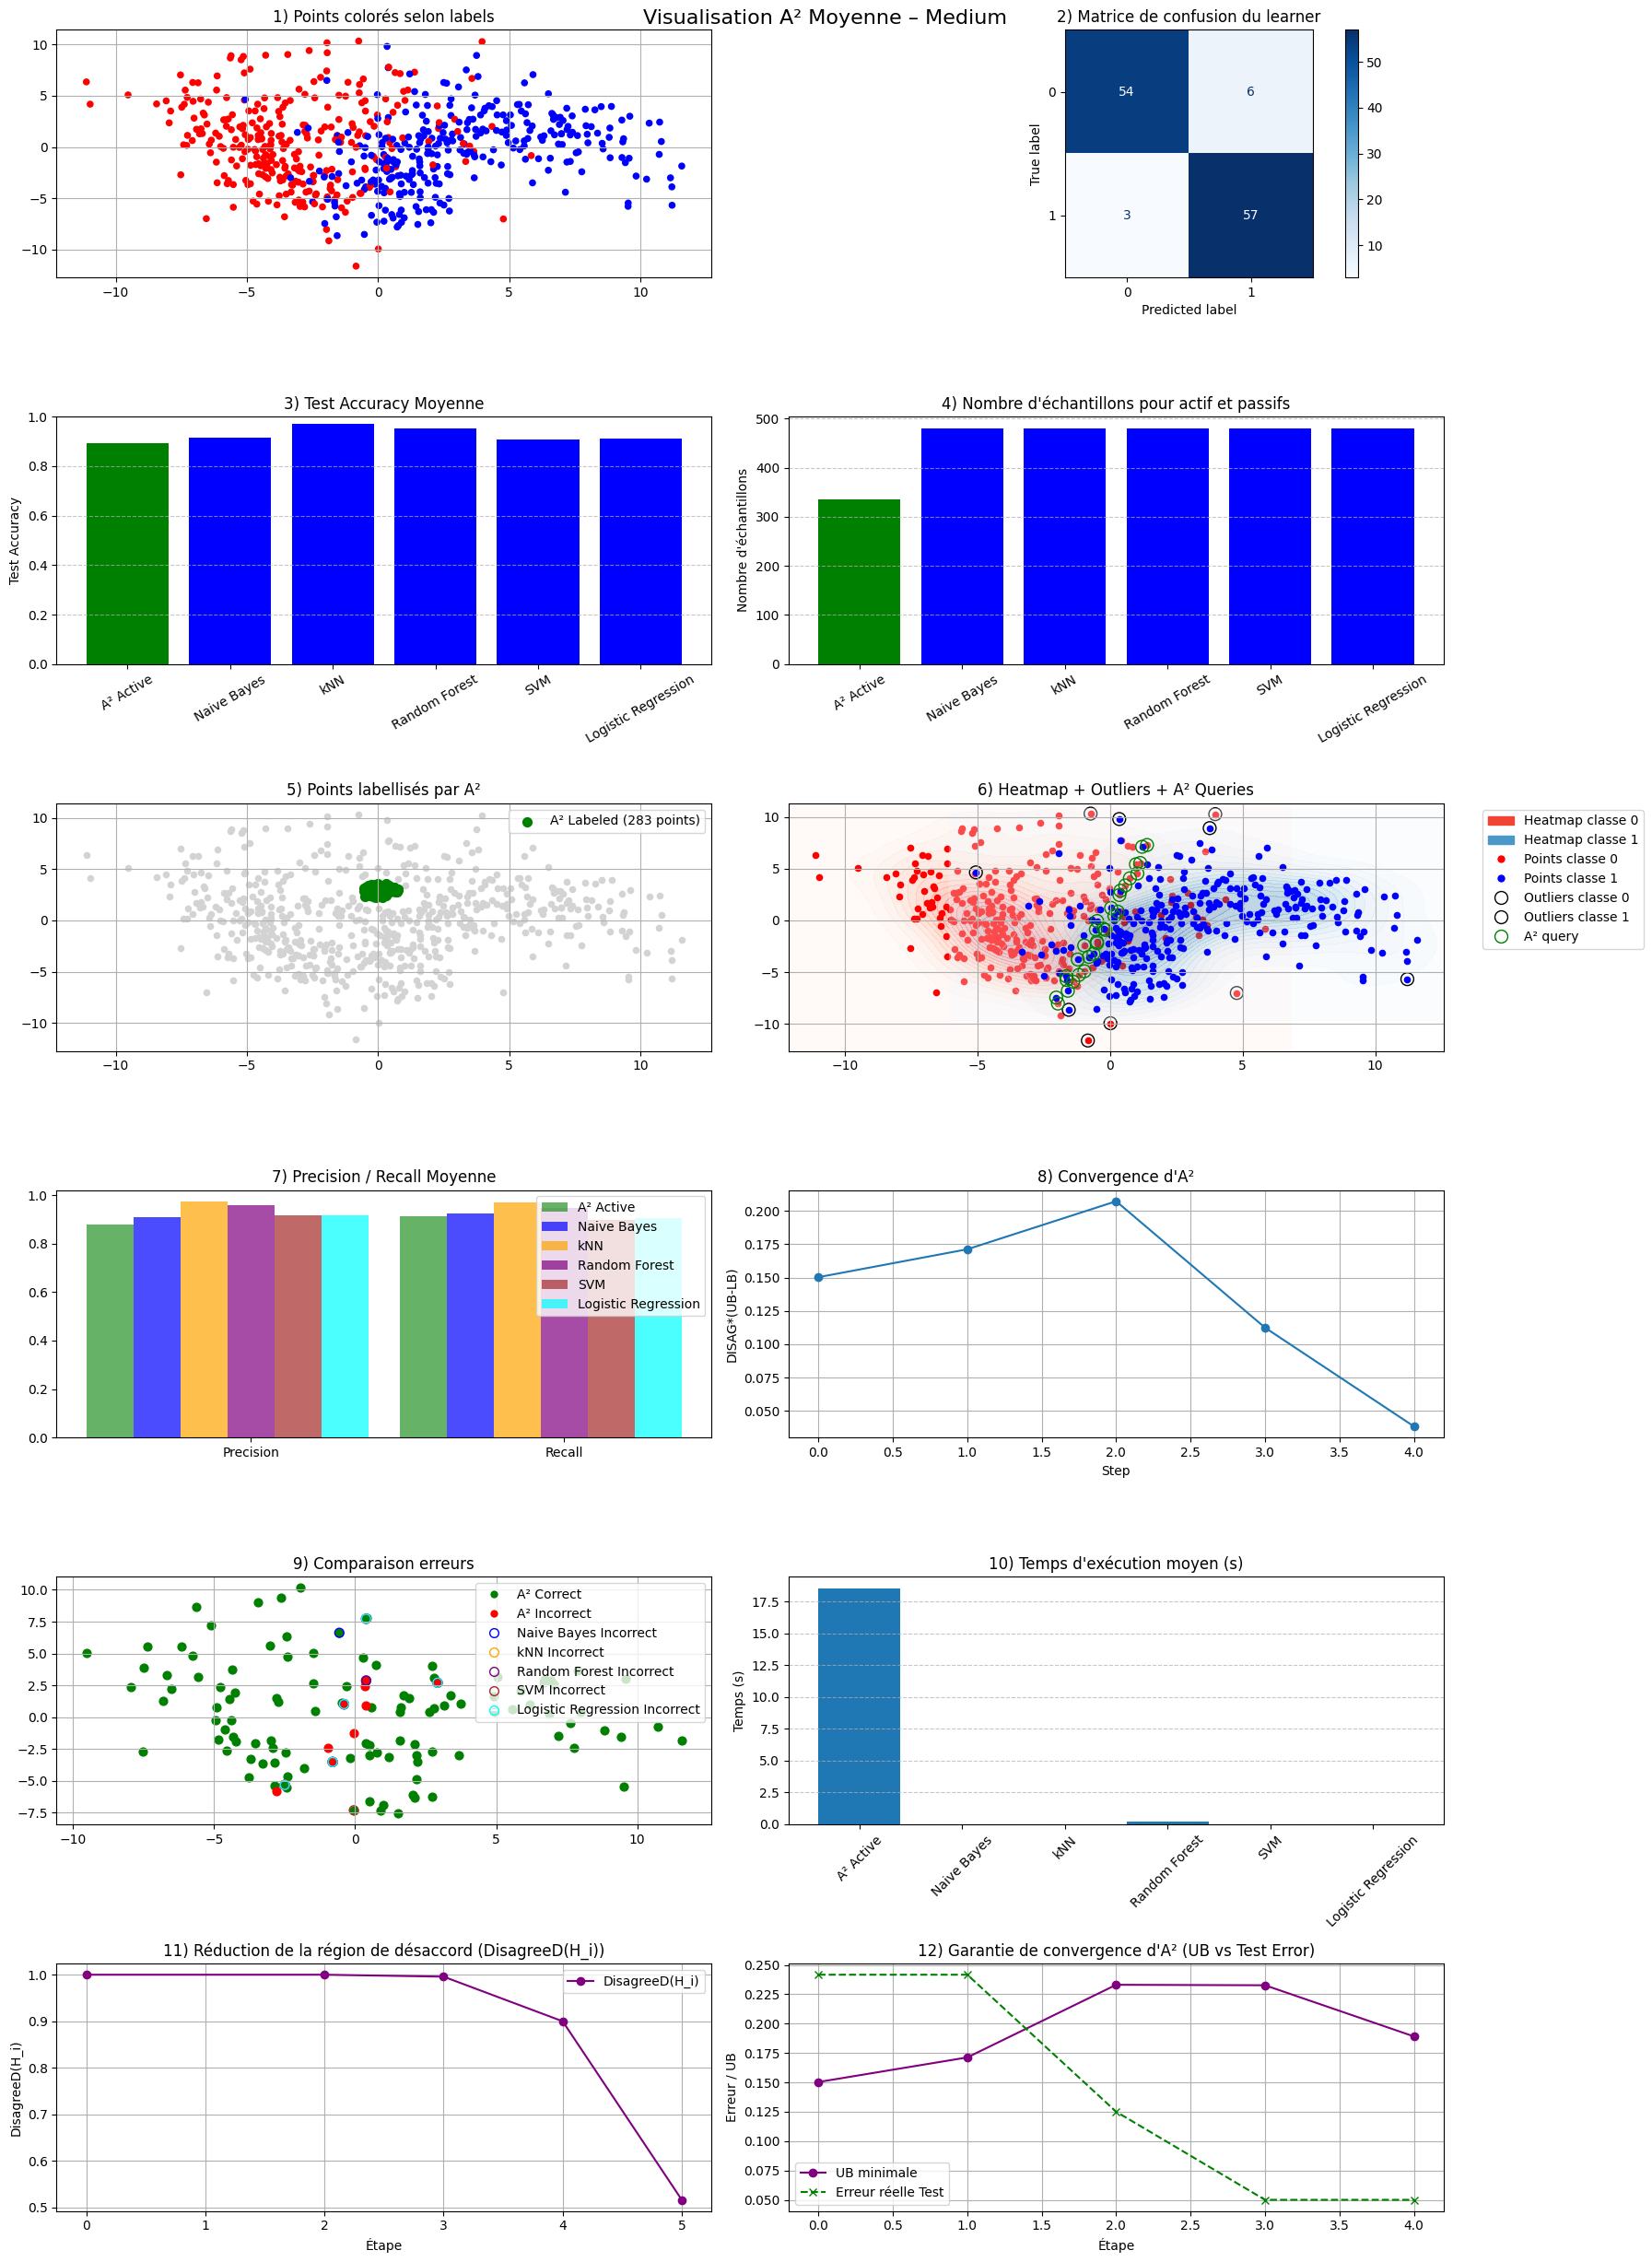

Run 1/10 on dataset BreastCancer with A²
Iteration 1, k=2, #labels=10, #hypotheses=1000, DIS=1.0, metric=0.1712
Iteration 1, k=3, #labels=31, #hypotheses=170, DIS=0.8681318681318682, metric=0.0903
Iteration 1, k=4, #labels=94, #hypotheses=100, DIS=0.6967032967032967, metric=0.0584
Iteration 2, k=6, #labels=283, #hypotheses=30, DIS=1.0, metric=0.0763
Iteration 2, k=7, #labels=307, #hypotheses=28, DIS=0.9357142857142857, metric=0.0700
Plus de points incertains à échantillonner, arrêt.
Run 2/10 on dataset BreastCancer with A²
Iteration 1, k=2, #labels=10, #hypotheses=1000, DIS=1.0, metric=0.1712
Iteration 1, k=3, #labels=31, #hypotheses=110, DIS=0.8263736263736263, metric=0.0860
Iteration 2, k=5, #labels=94, #hypotheses=27, DIS=1.0, metric=0.1071
Iteration 2, k=6, #labels=227, #hypotheses=10, DIS=0.664804469273743, metric=0.0567
Plus de points incertains à échantillonner, arrêt.
Run 3/10 on dataset BreastCancer with A²
Iteration 1, k=2, #labels=10, #hypotheses=1000, DIS=1.0, metric=0.1712

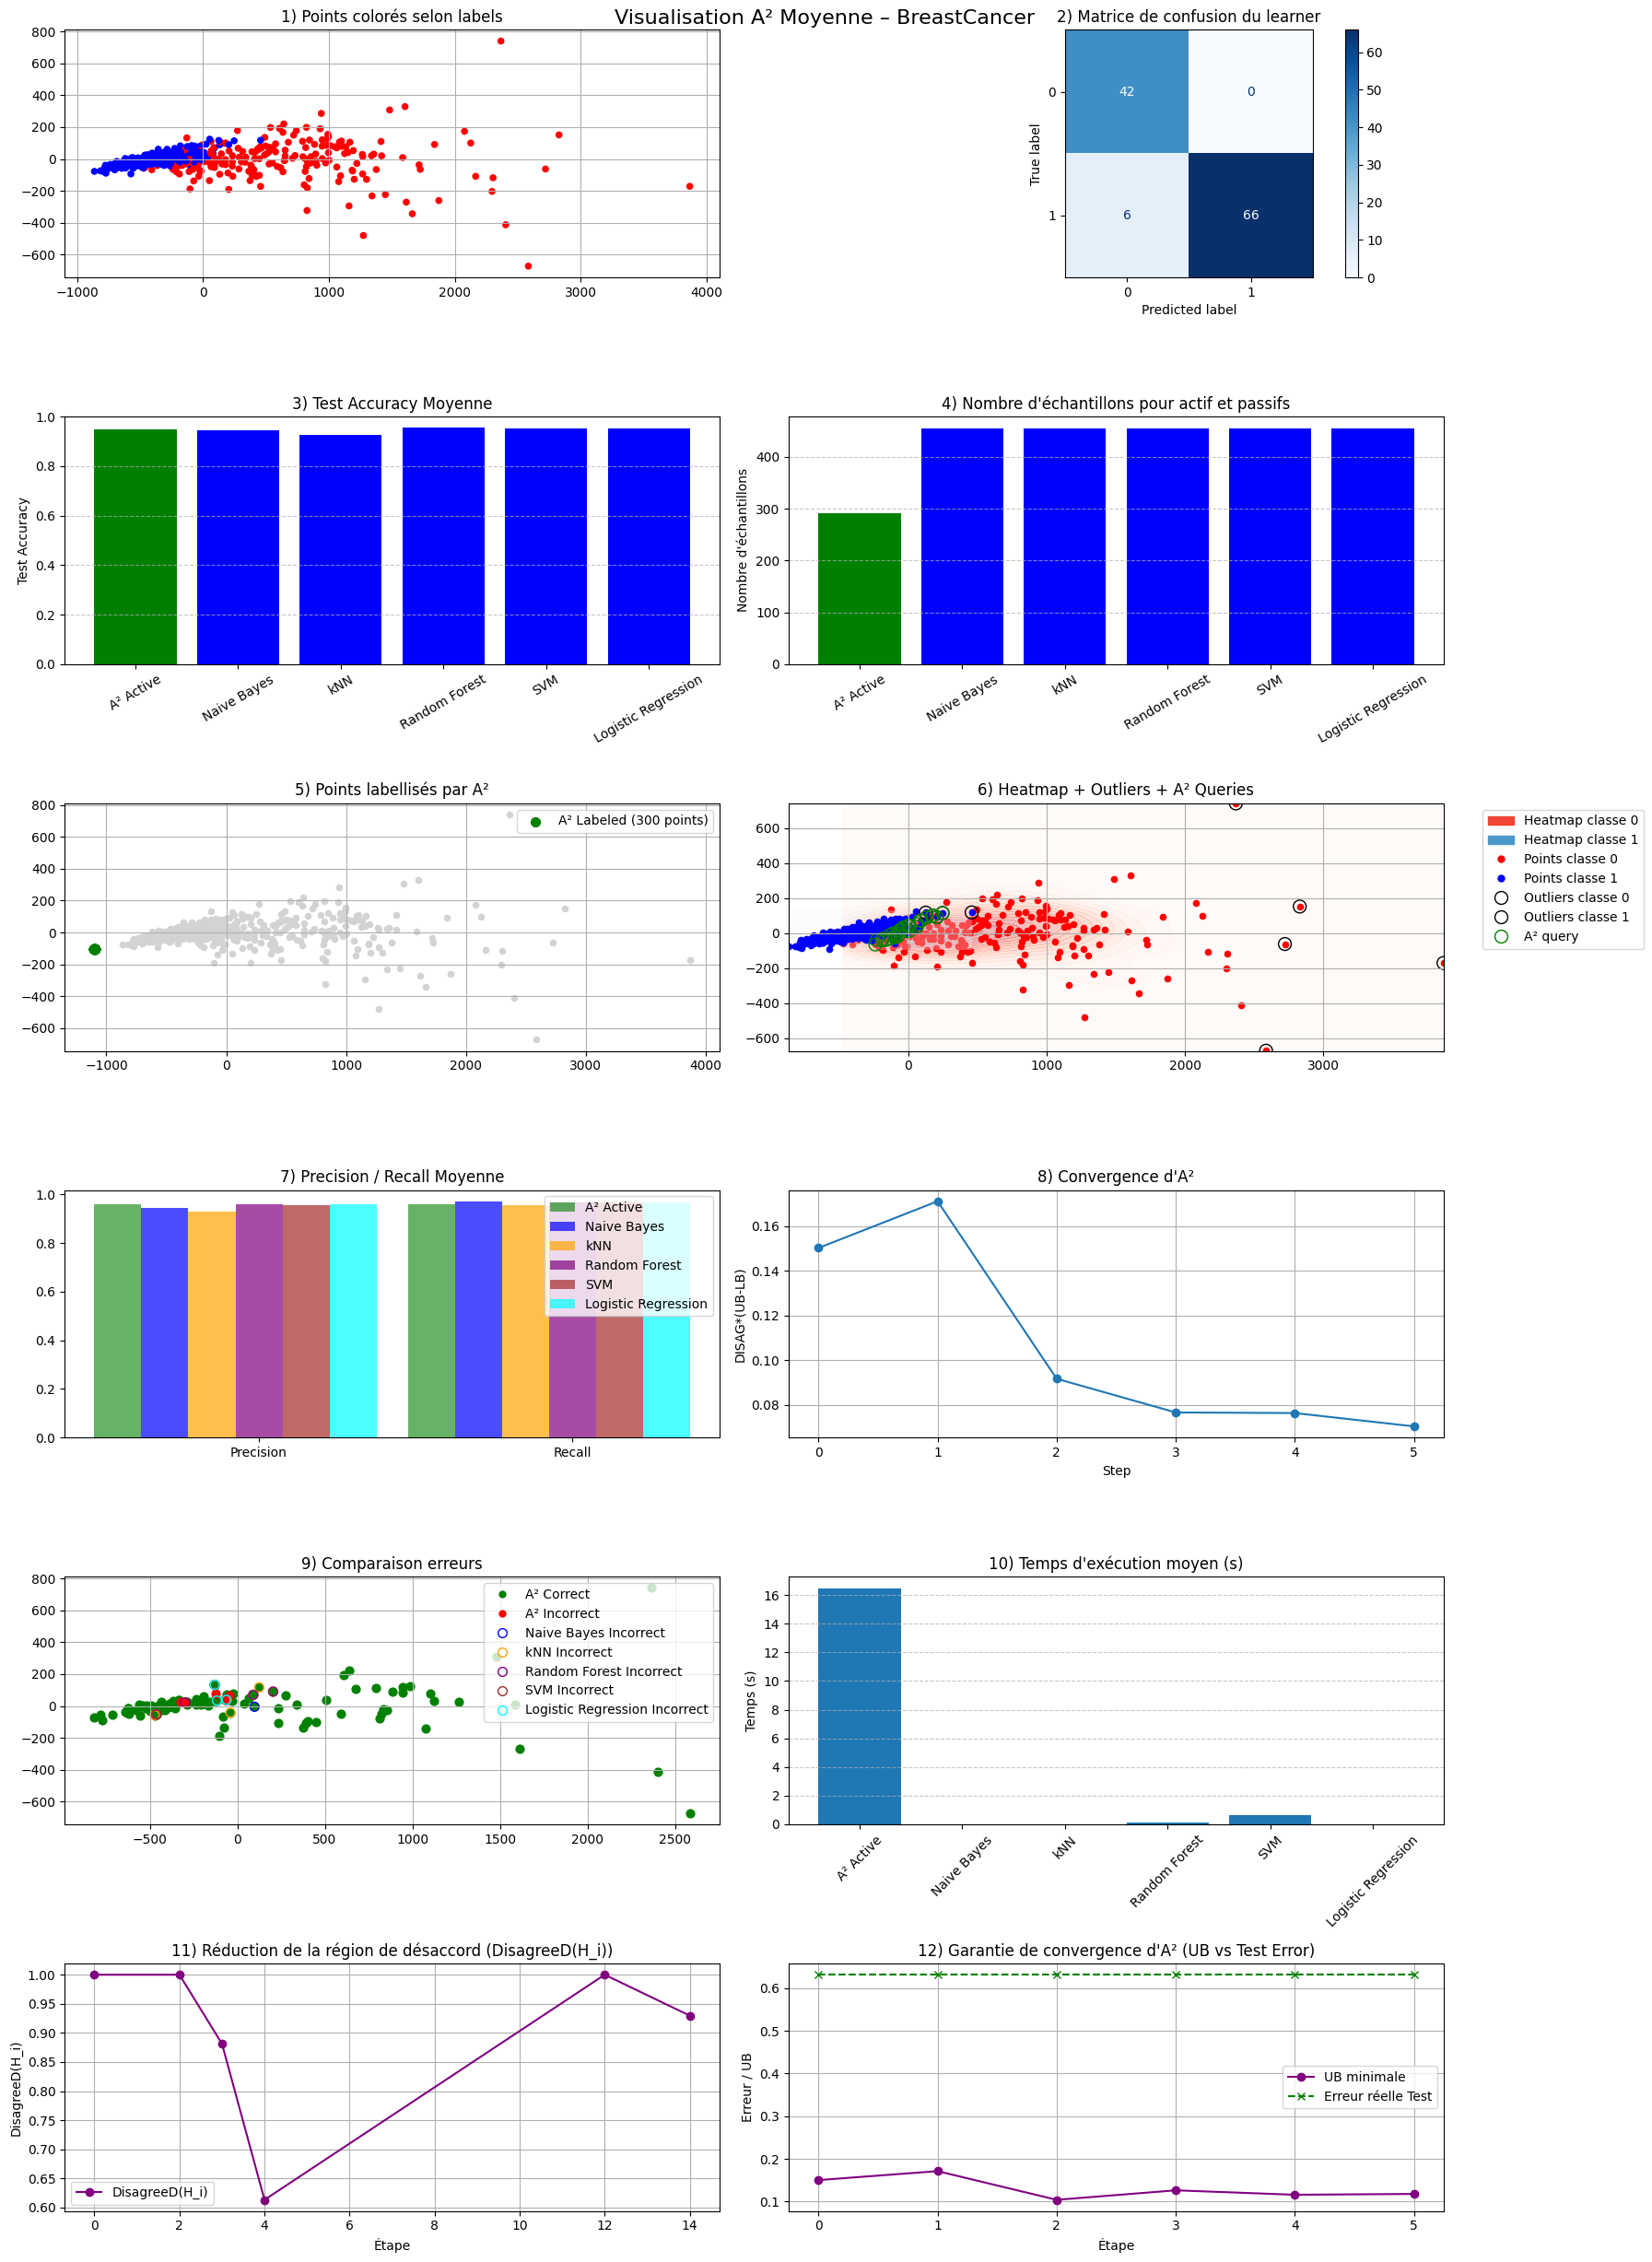

In [93]:
results_all = evaluate_classifiers_multiple_runs(
    datasets, 
    epsilon = 0.04, 
    delta = 0.1, 
    max_iter = 100,
    num_hypotheses = 1000, 
    test_size = 0.2, 
    num_runs = 10, 
    weight_scale = 0.5,
    threshold = 0, 
    scale = 0.35, 
    random_state=42)

In [94]:
# Affichage synthétique basé sur les métriques stockées
for r in results_all:
    dataset_name = r['dataset']

    # --- A² ---
    a2_test  = r['A2']['test']
    a2_train = r['A2']['train']
    print(f"Dataset: {dataset_name}")
    print(f"  A² (test) : Accuracy={a2_test['accuracy']:.4f}, Recall={a2_test['recall']:.4f}, F1={a2_test['f1']:.4f}, N_labeled={r['A2']['n_labeled']}")
    print(f"  A² (train): Accuracy={a2_train['accuracy']:.4f}, Recall={a2_train['recall']:.4f}, F1={a2_train['f1']:.4f}")

    # --- Passifs ---
    for clf_name, metrics in r['passive'].items():
        m_test  = metrics['test_metrics']
        m_train = metrics['train_metrics']
        print(f"  {clf_name} (test) : Accuracy={m_test['accuracy']:.4f}, Recall={m_test['recall']:.4f}, F1={m_test['f1']:.4f}")
        print(f"  {clf_name} (train): Accuracy={m_train['accuracy']:.4f}, Recall={m_train['recall']:.4f}, F1={m_train['f1']:.4f}")
    print("")


Dataset: Medium
  A² (test) : Accuracy=0.8925, Recall=0.9133, F1=0.8946, N_labeled=336
  A² (train): Accuracy=0.8740, Recall=0.8983, F1=0.8780
  Naive Bayes (test) : Accuracy=0.9158, Recall=0.9233, F1=0.9166
  Naive Bayes (train): Accuracy=0.8900, Recall=0.8917, F1=0.8910
  kNN (test) : Accuracy=0.9708, Recall=0.9700, F1=0.9709
  kNN (train): Accuracy=0.9650, Recall=0.9640, F1=0.9653
  Random Forest (test) : Accuracy=0.9533, Recall=0.9483, F1=0.9530
  Random Forest (train): Accuracy=0.9998, Recall=0.9996, F1=0.9998
  SVM (test) : Accuracy=0.9067, Recall=0.8983, F1=0.9059
  SVM (train): Accuracy=0.8915, Recall=0.8802, F1=0.8910
  Logistic Regression (test) : Accuracy=0.9117, Recall=0.9067, F1=0.9113
  Logistic Regression (train): Accuracy=0.8929, Recall=0.8855, F1=0.8929

Dataset: BreastCancer
  A² (test) : Accuracy=0.9465, Recall=0.9597, F1=0.9577, N_labeled=291
  A² (train): Accuracy=0.9497, Recall=0.9709, F1=0.9603
  Naive Bayes (test) : Accuracy=0.9439, Recall=0.9694, F1=0.9563
  Na

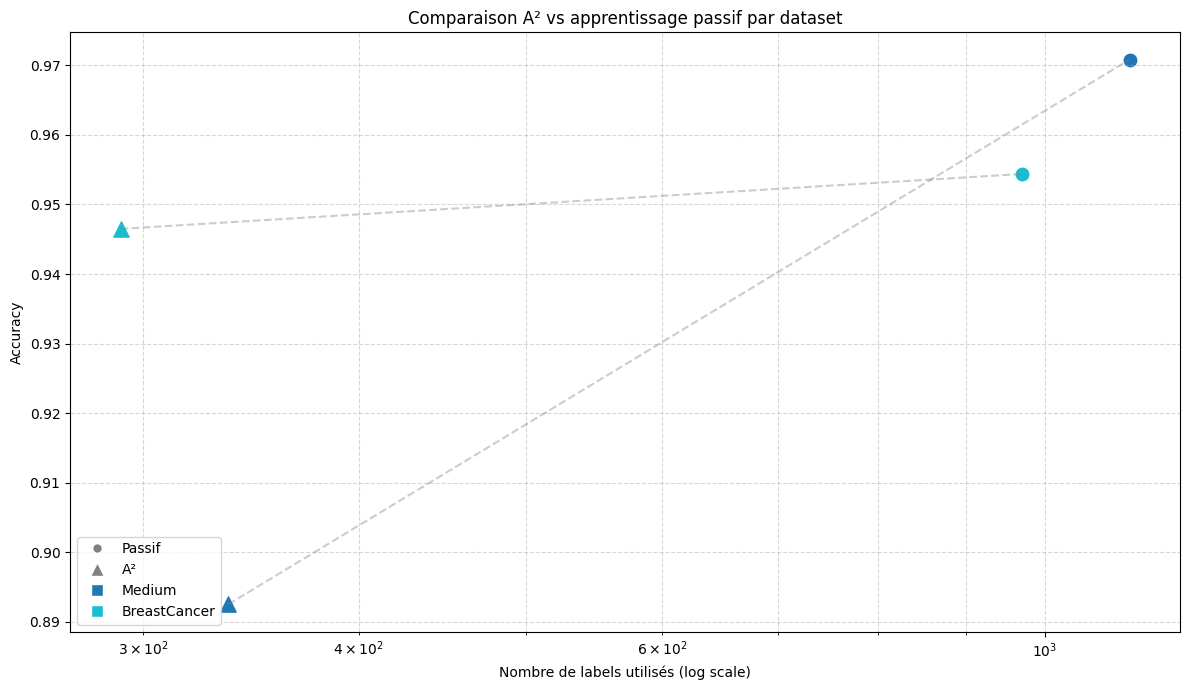

In [95]:
# Couleurs distinctes pour chaque dataset
dataset_names = [r['dataset'] for r in results_all]
colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_names)))  # ou autre colormap

plt.figure(figsize=(12,7))

for i, r in enumerate(results_all):
    dataset_name = r['dataset']
    color = colors[i]

    # --- A² ---
    n_labels_a2 = r['A2']['n_labeled']
    acc_a2 = r['A2']['test']['accuracy']  # test accuracy stockée

    # --- Passifs : meilleure accuracy parmi les classifieurs ---
    passive_accs = [metrics['test_metrics']['accuracy'] for metrics in r['passive'].values()]
    acc_passive = np.max(passive_accs)
    n_labels_passive = int(n_labels_a2 / 0.3)  # approximation test_size=0.3

    # Tracer Passif (rond)
    plt.scatter(n_labels_passive, acc_passive, color=color, marker='o', s=80)
    # Tracer A² (triangle)
    plt.scatter(n_labels_a2, acc_a2, color=color, marker='^', s=120)

    # Lignes grises
    plt.plot([n_labels_a2, n_labels_passive], [acc_a2, acc_passive], color='gray', linestyle='--', alpha=0.4)

# Axes
plt.xscale('log')
plt.xlabel("Nombre de labels utilisés (log scale)")
plt.ylabel("Accuracy")
plt.title("Comparaison A² vs apprentissage passif par dataset")
plt.grid(True, which="both", linestyle='--', alpha=0.5)

# Légende personnalisée
legend_elements = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor='gray', markersize=7, label='Passif'),
    Line2D([0],[0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='A²')
]

# Ajouter datasets
for name, color in zip(dataset_names, colors):
    legend_elements.append(Line2D([0],[0], marker='s', color='w', markerfacecolor=color, markersize=8, label=name))

plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0, 0))
plt.tight_layout()
plt.show()


Visualisation pour : Medium


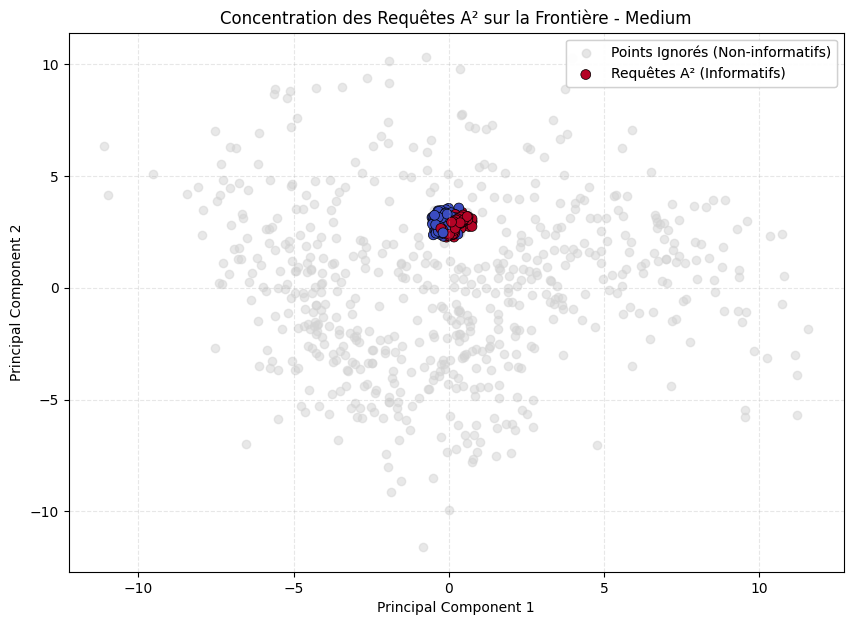

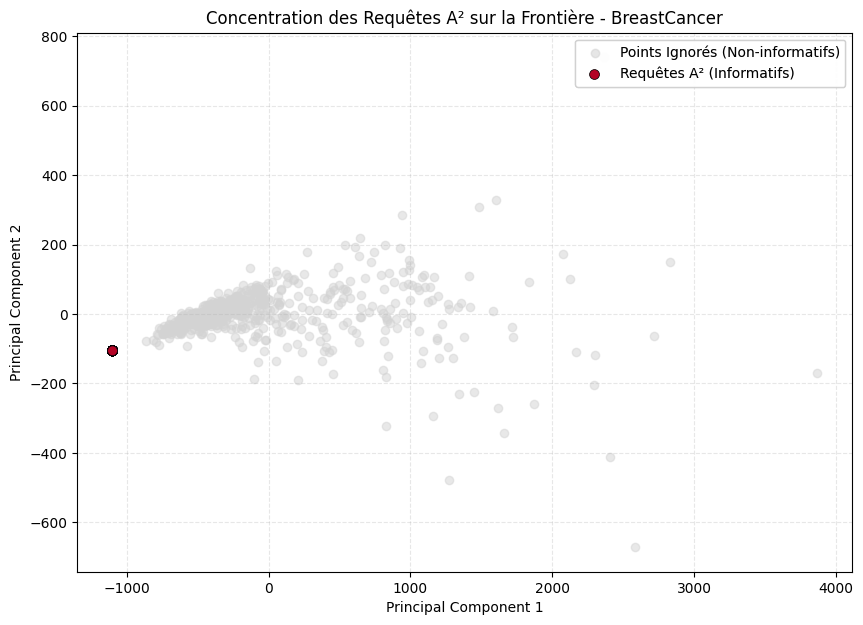

In [96]:
def plot_query_strategy(results, X, y, dataset_name):
    """
    Affiche la distribution spatiale des requêtes de l'algorithme A².
    Prouve que les points sélectionnés sont proches de la frontière de décision.
    """
    # Récupérer le résultat correspondant au dataset demandé
    res = next((r for r in results if r["dataset"] == dataset_name), None)
    if res is None:
        print(f"Dataset '{dataset_name}' introuvable dans les résultats.")
        return

    # Récupérer les indices des points labellisés
    # S_labeled est une liste de tuples (x, y). On doit retrouver x dans X.
    # Pour simplifier, on suppose que l'ordre n'a pas changé ou on fait un matching.
    # Note: Votre fonction retourne S_final qui contient les vecteurs.
    
    S_final = res["A2"]["S_labeled"]
    
    # On projette en 2D pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # On identifie les points "Query" vs "Ignored"
    # Attention: X a été scindé en train/test. Ici on visualise tout X pour simplifier, 
    # ou idéalement juste X_train (le pool).
    # Supposons qu'on visualise sur le pool d'entrainement utilisé dans la dernière run.
    
    # Pour faire simple et robuste : on re-projette les points de S_final avec la même PCA
    # Mais attention, PCA doit être fit sur X global.
    
    # Retrouver les indices des points de S_final dans X original est compliqué.
    # Astuce : On va plotter X_2d en gris, et on va sur-imprimer les points de S_final
    # en les projetant avec le MÊME transformateur PCA.
    
    X_queries = np.array([item[0] for item in S_final])
    X_queries_2d = pca.transform(X_queries)
    
    plt.figure(figsize=(10, 7))
    
    # 1. Fond : Tous les points (Le Pool)
    # On utilise un alpha très faible pour qu'ils soient discrets
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c='lightgray', alpha=0.5, label='Points Ignorés (Non-informatifs)')
    
    # 2. Premier plan : Les requêtes A²
    # On les colorie selon leur VRAIE classe pour voir la frontière
    y_queries = np.array([item[1] for item in S_final])
    
    # Scatter des requêtes
    scatter = plt.scatter(X_queries_2d[:, 0], X_queries_2d[:, 1], 
                          c=y_queries, cmap='coolwarm', 
                          edgecolor='k', s=50, linewidth=0.5, label='Requêtes A² (Informatifs)')
    
    plt.title(f"Concentration des Requêtes A² sur la Frontière - {dataset_name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 3. Ajout d'une légende pour les classes
    handles, _ = scatter.legend_elements(prop="colors")
    legend2 = plt.legend(handles, ["Classe 0", "Classe 1"], loc="lower right", title="Vrai Label")
    plt.gca().add_artist(plt.legend(loc="upper right")) # Remettre la première légende
    
    plt.show()

# --- EXEMPLE D'APPEL ---
# Assurez-vous d'avoir accès aux variables X et y originales du dataset
# Exemple pour 'Medium' (qui est dans datasets[0] si votre liste est ordonnée comme avant)

# Il faut retrouver le X et y du dataset Medium
# Supposons que datasets[0] est Medium
target_dataset = datasets[0] 
print(f"Visualisation pour : {target_dataset['name']}")

plot_query_strategy(results_all, target_dataset["X"], target_dataset["y"], "Medium")

# Faites pareil pour BreastCancer
target_bc = next(d for d in datasets if d["name"] == "BreastCancer")
plot_query_strategy(results_all, target_bc["X"], target_bc["y"], "BreastCancer")

Lancement de A² (Force Run)...
Iteration 1, k=2, #labels=4, #hypotheses=1000, DIS=1.0, metric=0.2708
Iteration 1, k=3, #labels=13, #hypotheses=182, DIS=0.89375, metric=0.1436
Iteration 1, k=4, #labels=40, #hypotheses=90, DIS=0.7604166666666666, metric=0.0728
Iteration 1, k=5, #labels=121, #hypotheses=44, DIS=0.5458333333333333, metric=0.0621
Iteration 2, k=7, #labels=306, #hypotheses=18, DIS=1.0, metric=0.0750
Plus de points incertains à échantillonner, arrêt.
Nombre d'étapes enregistrées : 6
Calcul de l'erreur réelle sur le Test set pour chaque étape de A²...
Simulation du Passif...


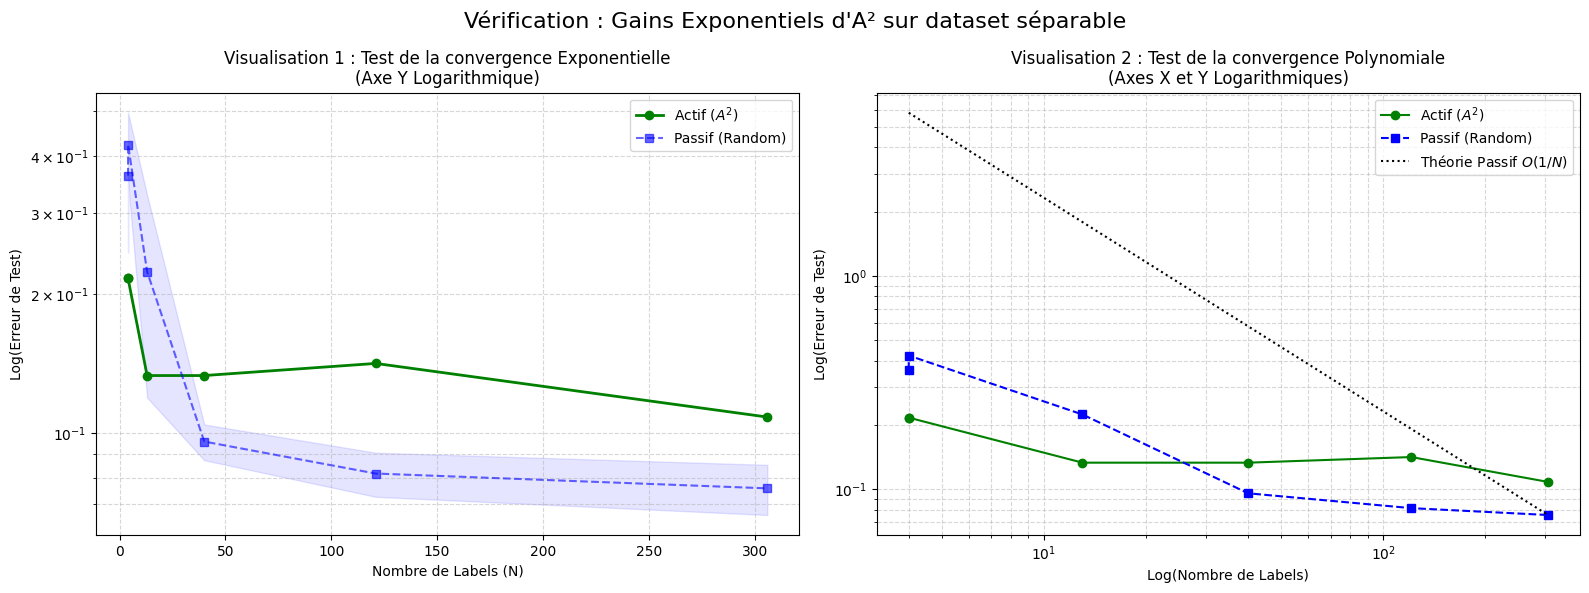

Lancement de A² (Force Run)...
Iteration 1, k=2, #labels=4, #hypotheses=1000, DIS=1.0, metric=0.2708
Iteration 1, k=3, #labels=13, #hypotheses=396, DIS=0.9428571428571428, metric=0.1515
Iteration 1, k=4, #labels=40, #hypotheses=342, DIS=0.8263736263736263, metric=0.0792
Iteration 1, k=5, #labels=121, #hypotheses=154, DIS=0.5252747252747253, metric=0.0473
Iteration 2, k=7, #labels=288, #hypotheses=48, DIS=1.0, metric=0.0773
Plus de points incertains à échantillonner, arrêt.
Nombre d'étapes enregistrées : 6
Calcul de l'erreur réelle sur le Test set pour chaque étape de A²...
Simulation du Passif...


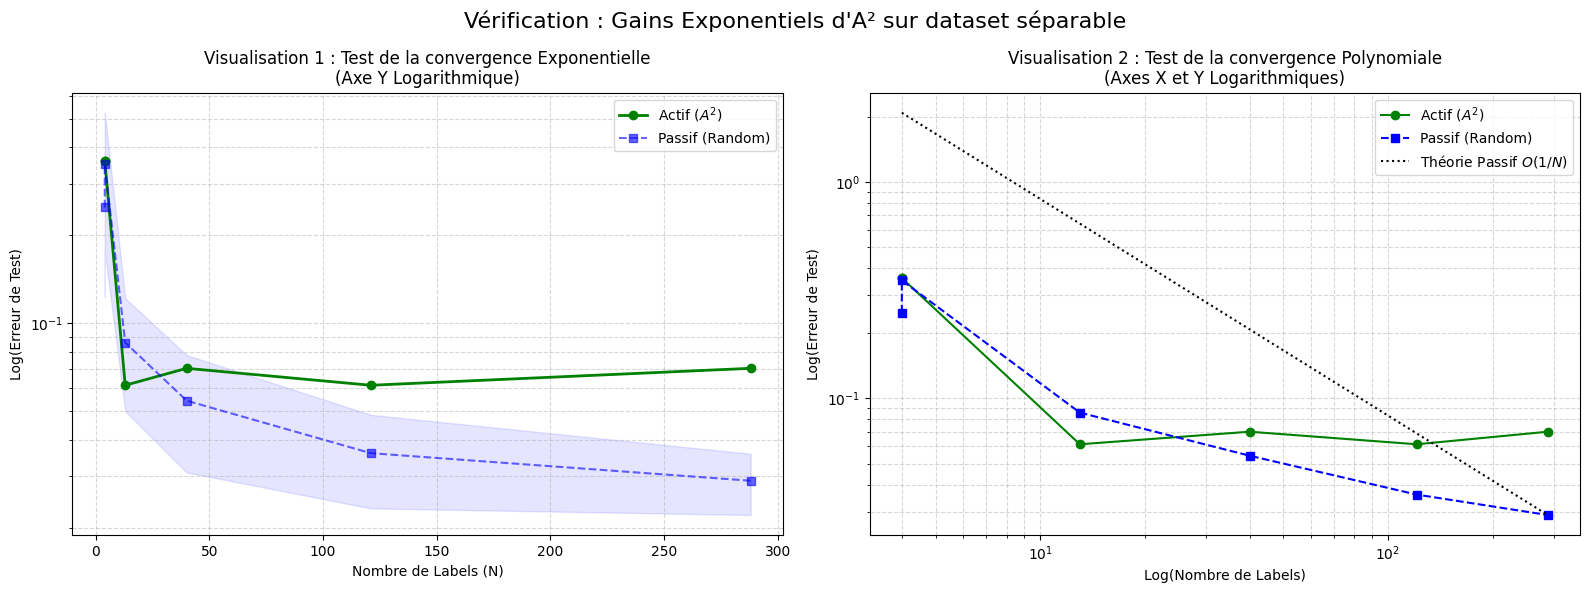

In [97]:
for dataset in datasets:

    # %%
    # 1. Configuration de l'expérience théorique "Conditions Favorables"

    # Split Train (Pool) / Test
    X_pool, X_test, y_pool, y_test = train_test_split(
        dataset["X"], dataset["y"], 
        test_size=0.2, random_state=42, stratify=dataset["y"]
    )

    # Normalisation (Important pour A2 et SVM/LogReg)
    scaler = MinMaxScaler()
    X_pool = scaler.fit_transform(X_pool)
    X_test = scaler.transform(X_test)


    # %%
    # 2. Exécution de A² avec "Forçage"
    print("Lancement de A² (Force Run)...")

    # Plus d'hypothèses pour maintenir un désaccord plus longtemps
    num_hypotheses = 1000 
    H, S_init_labels = create_H(X_pool, y_pool, num_hypotheses=num_hypotheses, noise_scale=0.3, n_init=4) # n_init réduit à 4
    oracle = oracle_factory(X_pool, y_pool)

    # ASTUCE : epsilon négatif pour désactiver l'arrêt précoce basé sur la borne
    # L'algo ne s'arrêtera que quand il n'y a plus de désaccord (DIS=0) ou max_iter atteint
    h_star, S_final, history = A2(
        H, X_pool, oracle, 
        epsilon=0.04,       # <--- HACK : Empêche l'arrêt prématuré
        delta=0.1, 
        max_iter=100,        # On limite le nombre d'étapes total
        threshold=0, 
        scale=0.35,          # Scale plus lâche pour garder des hypothèses plus longtemps
        initial_S=S_init_labels
    )

    # Affichez la longueur de l'historique pour vérifier
    print(f"Nombre d'étapes enregistrées : {len(history['iters'])}")

    # %%
    # 3. Extraction de la courbe d'apprentissage Actif (Erreur réelle sur Test)
    active_errors = []
    active_labels_count = []

    print("Calcul de l'erreur réelle sur le Test set pour chaque étape de A²...")
    for step_data in history["iters"]:
        # On récupère le nombre de labels utilisés à cette étape
        n_lab = step_data["n_labels"]
        
        # On récupère la meilleure hypothèse COURANTE (celle qui minimise la Borne Sup UB)
        # Note: Dans votre code A2, UB est calculé pour le snapshot H_snapshot
        H_snap = step_data["H_snapshot"]
        UB_snap = step_data["UB"]
        
        # Meilleure hypothèse théorique à cet instant
        best_h_idx = np.argmin(UB_snap)
        best_h = H_snap[best_h_idx]
        
        # Evaluation sur le VRAI test set (ground truth verification)
        y_pred = np.array([best_h(x) for x in X_test])
        error = 1.0 - accuracy_score(y_test, y_pred)
        
        active_labels_count.append(n_lab)
        active_errors.append(error)

    # %%
    # 4. Simulation de l'Apprentissage Passif (Random Sampling)
    # On aligne les budgets sur ceux utilisés par A² pour être comparable
    passive_errors = []
    passive_errors_std = [] # Pour afficher l'écart-type

    print("Simulation du Passif...")
    n_runs_passive = 10  # Moyenne sur plusieurs runs pour lisser

    for n in active_labels_count:
        if n == 0: 
            passive_errors.append(0.5)
            passive_errors_std.append(0.0)
            continue
            
        errors_at_n = []
        for _ in range(n_runs_passive):
            # Tirage aléatoire de n points
            idx = np.random.choice(len(X_pool), size=n, replace=False)
            X_train_pass = X_pool[idx]
            y_train_pass = y_pool[idx]
            
            # On doit avoir au moins 1 point de chaque classe pour entraîner
            if len(np.unique(y_train_pass)) < 2:
                errors_at_n.append(0.5) # Pire cas (random guess)
                continue
                
            # Modèle passif (Logistic Regression ou SVM Linéaire)
            clf = LogisticRegression(solver='liblinear', C=10) 
            clf.fit(X_train_pass, y_train_pass)
            err = 1.0 - clf.score(X_test, y_test)
            errors_at_n.append(err)
        
        passive_errors.append(np.mean(errors_at_n))
        passive_errors_std.append(np.std(errors_at_n))

    # %%
    # 5. Visualisation de la Preuve (Code Corrigé et Robuste)
    plt.figure(figsize=(16, 6))

    # --- Plot 1: Échelle Semi-Log (LogError vs N) ---
    plt.subplot(1, 2, 1)
    plt.title("Visualisation 1 : Test de la convergence Exponentielle\n(Axe Y Logarithmique)")

    # On s'assure qu'on a des données
    if len(active_labels_count) > 0:
        plt.semilogy(active_labels_count, active_errors, 'g-o', label=r'Actif ($A^2$)', linewidth=2)
        plt.semilogy(active_labels_count, passive_errors, 'b--s', label='Passif (Random)', alpha=0.6)

        # Zone d'écart type passif
        pass_err_arr = np.array(passive_errors)
        pass_std_arr = np.array(passive_errors_std)
        # On clip pour éviter les valeurs négatives en log
        lower_bound = np.maximum(1e-5, pass_err_arr - pass_std_arr) 
        plt.fill_between(active_labels_count, 
                        lower_bound, 
                        pass_err_arr + pass_std_arr, 
                        color='blue', alpha=0.1)

    plt.xlabel("Nombre de Labels (N)")
    plt.ylabel("Log(Erreur de Test)")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend()

    # --- Plot 2: Échelle Log-Log (LogError vs LogN) ---
    plt.subplot(1, 2, 2)
    plt.title("Visualisation 2 : Test de la convergence Polynomiale\n(Axes X et Y Logarithmiques)")

    if len(active_labels_count) > 0:
        plt.loglog(active_labels_count, active_errors, 'g-o', label=r'Actif ($A^2$)')
        plt.loglog(active_labels_count, passive_errors, 'b--s', label='Passif (Random)')

        # --- CORRECTION DE L'ERREUR INDEX OUT OF RANGE ---
        # On génère la ligne théorique seulement si on a assez de points (>1)
        if len(active_labels_count) > 1:
            # On prend les points à partir du 2ème pour éviter log(0) ou les instabilités du début
            x_guide = np.array(active_labels_count[1:])
            
            # On calcule la constante C pour aligner la courbe théorique sur le DERNIER point réel
            # y = C / x  =>  C = y * x
            last_idx = len(passive_errors) - 1
            if last_idx > 0:
                C = passive_errors[last_idx] * active_labels_count[last_idx]
                y_guide = C / x_guide
                plt.loglog(x_guide, y_guide, 'k:', label=r'Théorie Passif $O(1/N)$')

    plt.xlabel("Log(Nombre de Labels)")
    plt.ylabel("Log(Erreur de Test)")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend()

    plt.suptitle(f"Vérification : Gains Exponentiels d'A² sur dataset séparable", fontsize=16)
    plt.tight_layout()
    plt.show()

Analyse détaillée pour le dataset : Medium
Calcul de l'erreur réelle de toutes les hypothèses (Ground Truth)...
Meilleure erreur possible dans H (Plancher théorique) : 0.0889
Iteration 1, k=2, #labels=0, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=3, #labels=1, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=4, #labels=4, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=5, #labels=13, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=6, #labels=40, #hypotheses=901, DIS=1.0, metric=0.8953
Iteration 1, k=7, #labels=121, #hypotheses=901, DIS=1.0, metric=0.6019
Iteration 1, k=8, #labels=364, #hypotheses=901, DIS=1.0, metric=0.3878
Iteration 1, k=9, #labels=420, #hypotheses=901, DIS=1.0, metric=0.3667
Plus de points incertains à échantillonner, arrêt.
Analyse de l'historique...


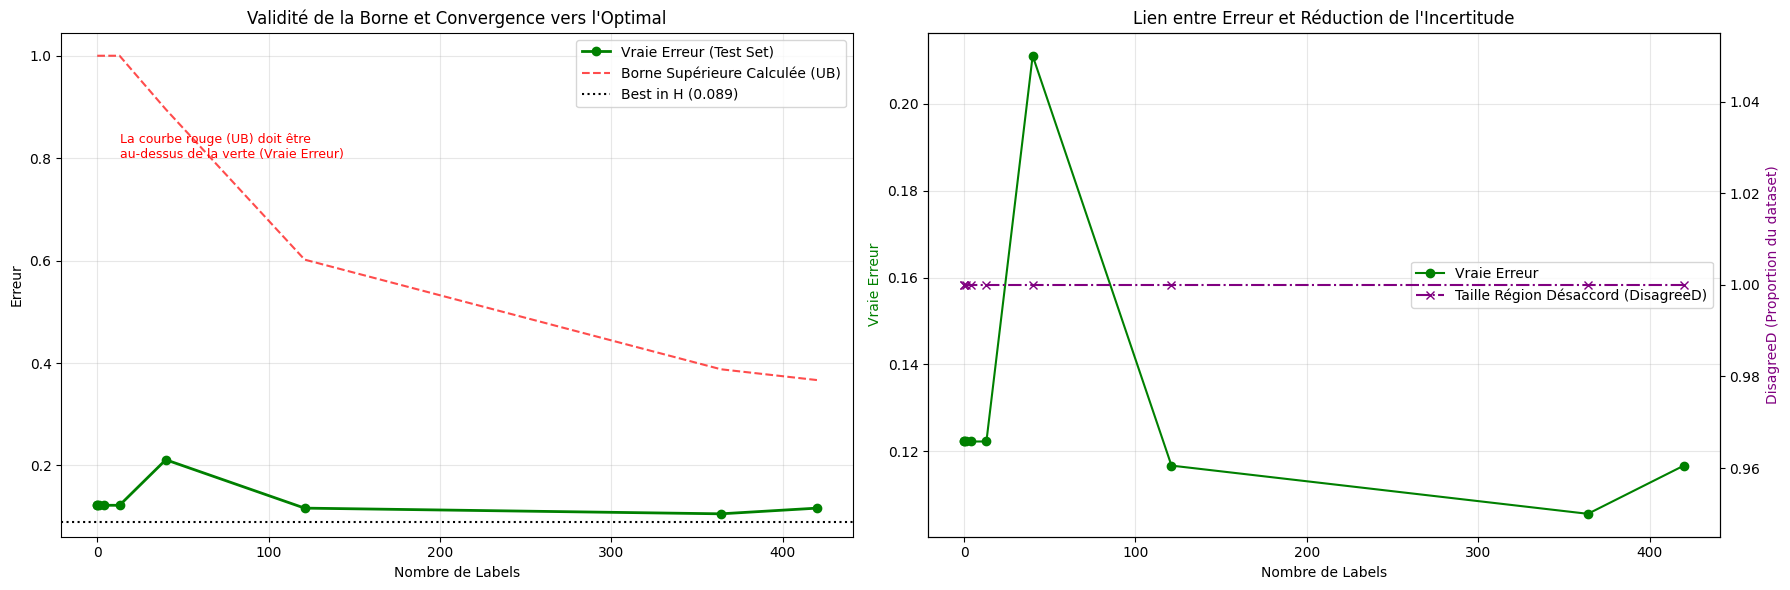

Analyse détaillée pour le dataset : BreastCancer
Calcul de l'erreur réelle de toutes les hypothèses (Ground Truth)...
Meilleure erreur possible dans H (Plancher théorique) : 0.0175
Iteration 1, k=2, #labels=0, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=3, #labels=1, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=4, #labels=4, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=5, #labels=13, #hypotheses=901, DIS=1.0, metric=1.0000
Iteration 1, k=6, #labels=40, #hypotheses=901, DIS=1.0, metric=0.8703
Iteration 1, k=7, #labels=121, #hypotheses=901, DIS=1.0, metric=0.5358
Iteration 1, k=8, #labels=364, #hypotheses=780, DIS=1.0, metric=0.3081
Iteration 1, k=9, #labels=398, #hypotheses=764, DIS=1.0, metric=0.2987
Plus de points incertains à échantillonner, arrêt.
Analyse de l'historique...


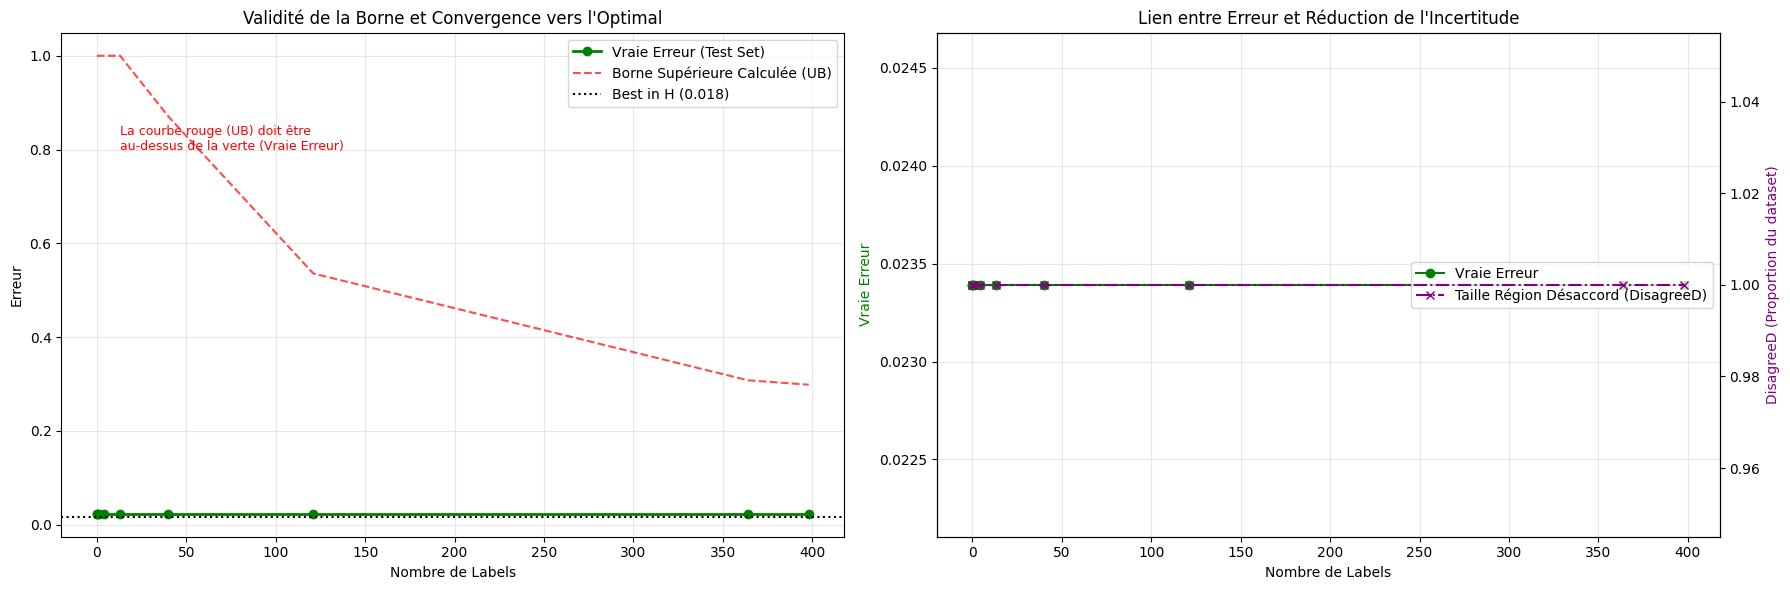

In [98]:
for dataset in datasets:

    print(f"Analyse détaillée pour le dataset : {dataset['name']}")

    # 1. Configuration de l'expérience théorique
    X_theo, y_theo = dataset["X"], dataset["y"]
    X_pool, X_test, y_pool, y_test = train_test_split(X_theo, y_theo, test_size=0.3, random_state=42)
    scaler = MinMaxScaler()
    X_pool = scaler.fit_transform(X_pool)
    X_test = scaler.transform(X_test)

    # Oracle
    clf_gold = LogisticRegression(solver='liblinear', C=1000).fit(X_pool, y_pool)
    w_star, b_star = clf_gold.coef_[0], clf_gold.intercept_[0]
    norm = np.linalg.norm(w_star)
    w_star, b_star = w_star/norm, b_star/norm

    # Génération de H (avec l'optimal inclus)
    H = []
    H.append(lambda x: 1 if np.dot(w_star, x) + b_star >= 0 else 0) # h*
    for scale in [0.05, 0.2, 0.5]:
        for _ in range(300):
            w = w_star + np.random.randn(len(w_star)) * scale
            b = b_star + np.random.randn() * scale
            w, b = w / np.linalg.norm(w), b / np.linalg.norm(w)
            H.append(lambda x, w=w, b=b: 1 if np.dot(w, x) + b >= 0 else 0)

    # --- ÉTAPE CLÉ 1 : Trouver le "Best in H" théorique ---
    print("Calcul de l'erreur réelle de toutes les hypothèses (Ground Truth)...")
    best_error_in_H = 1.0
    for h in H:
        y_pred = np.array([h(x) for x in X_test])
        err = 1.0 - accuracy_score(y_test, y_pred)
        if err < best_error_in_H:
            best_error_in_H = err
    print(f"Meilleure erreur possible dans H (Plancher théorique) : {best_error_in_H:.4f}")

    # 2. Exécution A²
    oracle = oracle_factory(X_pool, y_pool)
    h_star, S_final, history = A2(
        H, X_pool, oracle, epsilon=0.0, delta=0.1, max_iter=60, 
        threshold=0, scale=3.0, initial_S=[]
    )

    # 3. Extraction des métriques internes
    steps = []
    true_errors = []
    upper_bounds = []
    disagreements = []
    regrets = []

    print("Analyse de l'historique...")
    for step_data in history["iters"]:
        steps.append(step_data["n_labels"])
        
        # Récupérer l'hypothèse choisie (celle qui minimise UB)
        idx_selected = np.argmin(step_data["UB"])
        h_selected = step_data["H_snapshot"][idx_selected]
        ub_selected = step_data["UB"][idx_selected]
        dis_val = step_data["DIS"]
        
        # Calculer sa VRAIE erreur sur le test set
        y_pred = np.array([h_selected(x) for x in X_test])
        true_err = 1.0 - accuracy_score(y_test, y_pred)
        
        true_errors.append(true_err)
        upper_bounds.append(ub_selected) # La borne que l'algo pensait avoir
        disagreements.append(dis_val)
        regrets.append(true_err - best_error_in_H) # Distance au meilleur

    # %%
    # 4. Visualisation pour le rapport
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # --- GRAPHIQUE 1 : Convergence et Validité de la Borne ---
    # Vérifie : "A² selects classifier minimizing UB" et "Converges to best in H"
    ax[0].plot(steps, true_errors, 'g-o', label='Vraie Erreur (Test Set)', linewidth=2)
    ax[0].plot(steps, upper_bounds, 'r--', label='Borne Supérieure Calculée (UB)', alpha=0.7)
    ax[0].axhline(y=best_error_in_H, color='k', linestyle=':', label=f'Best in H ({best_error_in_H:.3f})')

    ax[0].set_title("Validité de la Borne et Convergence vers l'Optimal")
    ax[0].set_xlabel("Nombre de Labels")
    ax[0].set_ylabel("Erreur")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    ax[0].text(steps[len(steps)//2], upper_bounds[0]*0.8, 
            "La courbe rouge (UB) doit être\nau-dessus de la verte (Vraie Erreur)", 
            color='red', fontsize=9)

    # --- GRAPHIQUE 2 : Corrélation Erreur / Région de Désaccord ---
    # Vérifie : "Progression rapide puis stabilisation quand région réduite"
    ax2 = ax[1].twinx() # Deuxième axe Y pour le désaccord

    ln1 = ax[1].plot(steps, true_errors, 'g-o', label='Vraie Erreur')
    ln2 = ax2.plot(steps, disagreements, 'purple', linestyle='-.', marker='x', label='Taille Région Désaccord (DisagreeD)')

    ax[1].set_xlabel("Nombre de Labels")
    ax[1].set_ylabel("Vraie Erreur", color='g')
    ax2.set_ylabel("DisagreeD (Proportion du dataset)", color='purple')
    ax[1].set_title("Lien entre Erreur et Réduction de l'Incertitude")

    # Légende combinée
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax[1].legend(lns, labs, loc='center right')
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()